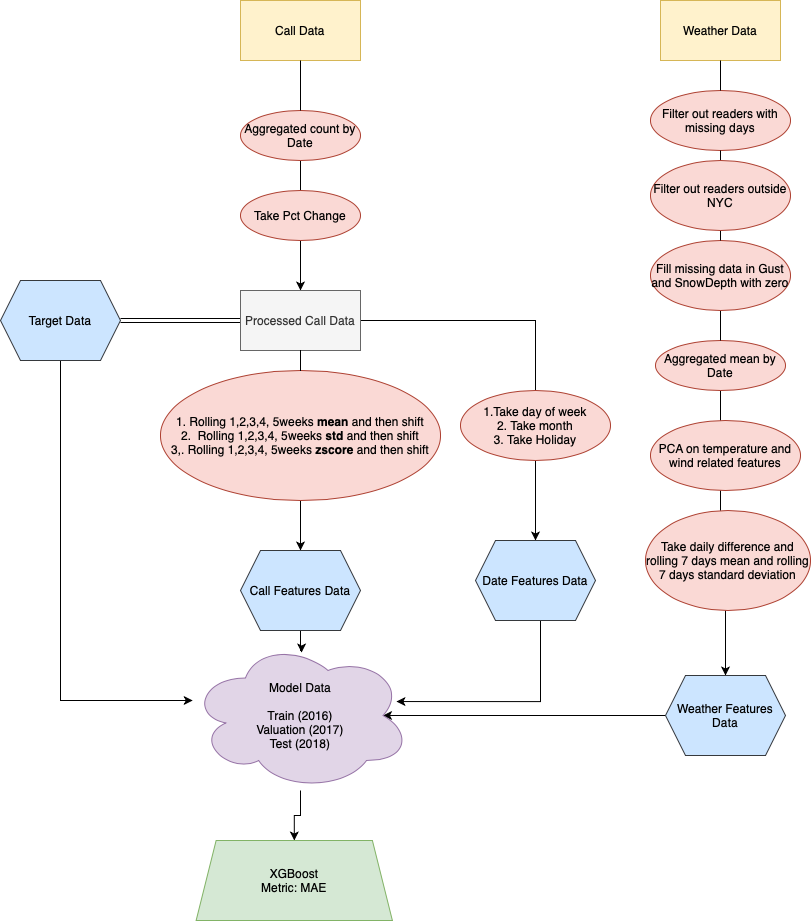

In [1]:
from IPython.display import Image
Image(filename='Downloads/flowchart_72.png') 

In [2]:
import pandas as pd
import dask.dataframe as dd

In [3]:
col =['Created Date', 'Agency', 'Unique Key']
df = dd.read_csv(
    'Downloads/311-2016-2018.csv',
    blocksize=16 * 1024 * 1024,
    usecols=col,
)

def process(df):
    df['Created Date'] = df['Created Date'].map(lambda x:x.split()[0])
    res = df.groupby(['Created Date'])['Unique Key'].count()
    return res

result = process(df)
result = result.compute(num_workers=4)

In [4]:
result.index = list(map(lambda x: pd.to_datetime(x,format='%m/%d/%Y'),result.index))
target = result.sort_index().pct_change()
del result

<AxesSubplot:>

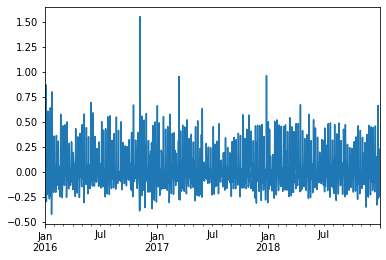

In [5]:
target.plot()

# Feature Eng

In [6]:
num_weeks = 5

In [7]:
list_trend_df = []
for window in range(7,7*(1+num_weeks),7):
    res = target.rolling(window).mean().to_frame().rename(columns={"Unique Key":"trend_"+str(window)}).shift(1)
    #corr = res.join(target).corr().iloc[-1,0]
    list_trend_df.append(res)
trend_df = pd.concat(list_trend_df,axis=1)

In [8]:
list_vol_df = []
for window in range(7,7*(1+num_weeks),7):
    res = target.rolling(window).std().to_frame().rename(columns={"Unique Key":"vol_"+str(window)}).shift(1)
    list_vol_df.append(res)
vol_df = pd.concat(list_vol_df,axis=1)

In [9]:
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

list_zscore_df = []
for window in range(7,7*(1+num_weeks),7):
    res = zscore(target, window).to_frame().rename(columns={"Unique Key":"zscore_"+str(window)})
    list_zscore_df.append(res)
zscore_df = pd.concat(list_zscore_df,axis=1)

In [10]:
call_data = zscore_df.join(trend_df).join(vol_df)

In [11]:
call_data

,zscore_7,zscore_14,zscore_21,zscore_28,zscore_35,trend_7,trend_14,trend_21,trend_28,trend_35,vol_7,vol_14,vol_21,vol_28,vol_35
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,0.245763,0.290512,0.341390,0.352970,0.306129,0.014711,0.016345,0.010257,0.011080,0.019917,0.339499,0.270098,0.245228,0.233338,0.238762
2018-12-28,-0.186814,-0.148381,-0.142388,-0.135485,-0.190016,0.043685,0.024327,0.019595,0.016679,0.029555,0.335628,0.270598,0.244386,0.233330,0.234509
2018-12-29,-0.889150,-1.091363,-1.140170,-1.188481,-1.216657,0.020291,0.029357,0.018436,0.018261,0.018576,0.332727,0.269064,0.244491,0.232951,0.226980
2018-12-30,-0.138672,-0.132715,-0.101574,-0.116446,-0.124389,0.031832,0.025697,0.015357,0.017544,0.018631,0.319512,0.272782,0.247621,0.233783,0.226912


<AxesSubplot:>

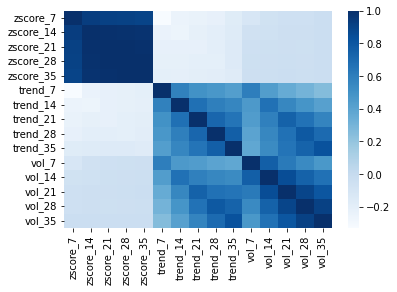

In [12]:
import seaborn as sns
sns.heatmap(zscore_df.join(trend_df).join(vol_df).corr(),cmap='Blues')

In [13]:
weather_data = pd.read_csv('Downloads/weather_NY_2010_2018Nov.csv')
weather_data['date'] = weather_data['Year'].apply(str)+weather_data['Month'].apply(str).apply(lambda x:x.zfill(2))+weather_data['Day'].apply(str).apply(lambda x:x.zfill(2))
weather_data['date'] = list(map(lambda x: pd.to_datetime(x),weather_data['date']))
weather_data.head()

,USAF,WBAN,StationName,State,Latitude,Longitude,MeanTemp,MinTemp,MaxTemp,DewPoint,...,WindSpeed,MaxSustainedWind,Gust,Rain,SnowDepth,SnowIce,Year,Month,Day,date
0,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,27.6,24.8,30.9,25.0,...,1.3,6.0,NaN,0,NaN,1,2010,1,1,2010-01-01
1,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,-3.2,-20.9,17.1,-9.6,...,3.3,9.9,NaN,0,NaN,1,2010,1,10,2010-01-10
2,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,20.9,17.1,24.1,15.1,...,6.8,12.0,19.0,0,NaN,1,2010,1,11,2010-01-11
3,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,13.8,5.0,19.9,8.5,...,4.4,8.0,15.9,0,NaN,1,2010,1,12,2010-01-12
4,726228,94740,ADIRONDACK REGIONAL ARPT,NY,44.385,-74.207,6.3,-8.0,19.0,1.9,...,3.3,5.1,NaN,0,NaN,1,2010,1,13,2010-01-13


In [14]:
weather_data.isnull().sum()[weather_data.isnull().sum()>0]

MinTemp                 53
MaxTemp                 53
DewPoint             39146
Percipitation         1619
WindSpeed            13371
MaxSustainedWind     27200
Gust                 84078
SnowDepth           155429
dtype: int64

<AxesSubplot:xlabel='date'>

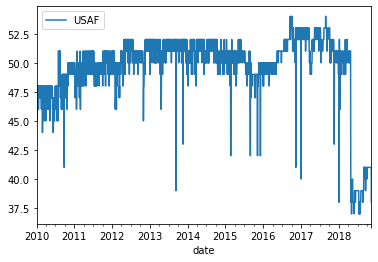

In [15]:
weather_data.groupby(['date']).count()['USAF'].to_frame().plot()#.sort_values('USAF')

In [16]:
len(weather_data['date'].unique())

3238

3


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

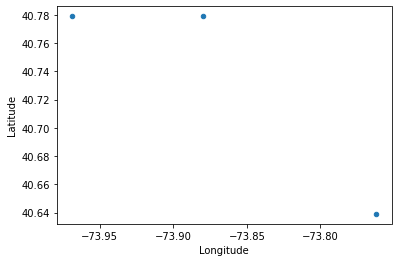

In [17]:
tmp = weather_data.groupby(['Latitude','Longitude'])['date'].nunique()
tmp = tmp[tmp==3238].to_frame().reset_index()
tmp = tmp[(tmp['Latitude']<40.912941) & (tmp['Latitude']>40.498044) & (tmp['Longitude']>-74.255211) & (tmp['Longitude']<-73.700384)]
print(len(tmp))
tmp.plot.scatter('Longitude','Latitude')

In [18]:
weather_data = weather_data[(weather_data['Latitude'].isin(tmp['Latitude'])) & (weather_data['Longitude'].isin(tmp['Longitude']))]

In [19]:
weather_data.isnull().sum()[weather_data.isnull().sum()>0]

Percipitation         19
WindSpeed             53
MaxSustainedWind      53
Gust                2968
SnowDepth           8879
dtype: int64

In [20]:
weather_data[weather_data['Percipitation'].isnull()]['Latitude'].unique()

array([40.779, 40.639])

In [21]:
weather_data[weather_data['WindSpeed'].isnull()]['Latitude'].unique()

array([40.779])

In [22]:
weather_data[weather_data['MaxSustainedWind'].isnull()]['Latitude'].unique()

array([40.779])

In [23]:
weather = ['MeanTemp', 'MinTemp', 'MaxTemp', 'DewPoint', 'Percipitation',
       'WindSpeed', 'MaxSustainedWind', 'Gust', 'Rain', 'SnowDepth', 'SnowIce']

commons = ['MeanTemp', 'MinTemp', 'MaxTemp', 'DewPoint', 'Percipitation',
       'WindSpeed', 'MaxSustainedWind','Gust']
temp = ['MeanTemp', 'MinTemp', 'MaxTemp', 'DewPoint']
wind = ['WindSpeed', 'MaxSustainedWind']
extremes = ['Gust', 'Rain', 'SnowDepth', 'SnowIce']

In [24]:
weather_data['Gust'] = weather_data['Gust'].fillna(0)
weather_data['SnowDepth'] = weather_data['SnowDepth'].fillna(0)


weather_df = weather_data.groupby('date').mean()

In [25]:
weather_df.isnull().sum()

USAF                0
WBAN                0
Latitude            0
Longitude           0
MeanTemp            0
MinTemp             0
MaxTemp             0
DewPoint            0
Percipitation       0
WindSpeed           0
MaxSustainedWind    0
Gust                0
Rain                0
SnowDepth           0
SnowIce             0
Year                0
Month               0
Day                 0
dtype: int64

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
X = weather_df[temp]
weather_df['temp'] = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.9610561]


In [27]:
pca = PCA(n_components=1)
X = weather_df[wind]
weather_df['wind'] = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.94352608]


In [28]:
weather_df[weather].corr()
use_cols = ['temp','Percipitation']+wind+extremes

In [29]:
binary = ["Rain", "SnowIce"]
continu = ['temp','Percipitation','WindSpeed','MaxSustainedWind','Gust','SnowDepth']
model_df = weather_df[use_cols]

In [30]:
model_df.isnull().sum()

temp                0
Percipitation       0
WindSpeed           0
MaxSustainedWind    0
Gust                0
Rain                0
SnowDepth           0
SnowIce             0
dtype: int64

In [31]:
weather_input = model_df.diff()

In [32]:
weather_input = weather_input.rolling(7).mean().add_prefix('trend_').shift(1).join(
weather_input.rolling(7).std().add_prefix('vol_').shift(1)
).join(weather_input.shift(1))

In [33]:
#data = call_data.join(weather_input)
data = weather_input.join(call_data, how = 'right')

In [34]:
data.isnull().sum()/data.shape[0]

trend_temp                0.044708
trend_Percipitation       0.044708
trend_WindSpeed           0.044708
trend_MaxSustainedWind    0.044708
trend_Gust                0.044708
trend_Rain                0.044708
trend_SnowDepth           0.044708
trend_SnowIce             0.044708
vol_temp                  0.044708
vol_Percipitation         0.044708
vol_WindSpeed             0.044708
vol_MaxSustainedWind      0.044708
vol_Gust                  0.044708
vol_Rain                  0.044708
vol_SnowDepth             0.044708
vol_SnowIce               0.044708
temp                      0.044708
Percipitation             0.044708
WindSpeed                 0.044708
MaxSustainedWind          0.044708
Gust                      0.044708
Rain                      0.044708
SnowDepth                 0.044708
SnowIce                   0.044708
zscore_7                  0.007299
zscore_14                 0.013686
zscore_21                 0.020073
zscore_28                 0.026460
zscore_35           

In [35]:
data['weekday'] = [i.weekday() for i in data.index]
data['month'] = [i.month for i in data.index]

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2016-01-01', end='2018-12-31').to_pydatetime()
data['holiday'] = [ i in holidays for i in data.index]
data = data.join(target.to_frame().rename(columns={'Unique Key':'target'})).iloc[1:,:]

<AxesSubplot:>

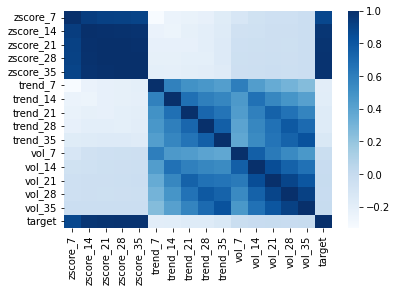

In [36]:
tmp = data[['zscore_7', 'zscore_14', 'zscore_21', 'zscore_28', 'zscore_35',
       'trend_7', 'trend_14', 'trend_21', 'trend_28', 'trend_35', 'vol_7',
       'vol_14', 'vol_21', 'vol_28', 'vol_35','target']].corr()

import seaborn as sns
sns.heatmap(tmp,cmap='Blues')

<AxesSubplot:ylabel='weekday'>

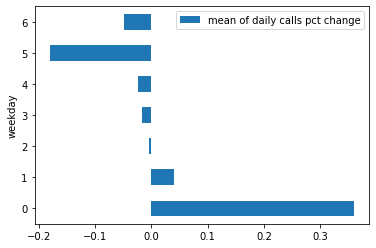

In [37]:
data.groupby('weekday').mean()['target'].to_frame().rename(
    columns={'target':'mean of daily calls pct change'}).plot(kind='barh')

<AxesSubplot:ylabel='month'>

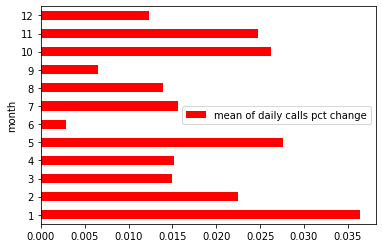

In [38]:
data.groupby('month').mean()['target'].to_frame().rename(
    columns={'target':'mean of daily calls pct change'}).plot(kind='barh',color='r')

<AxesSubplot:ylabel='holiday'>

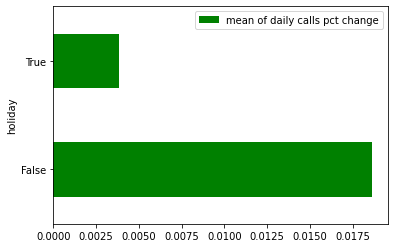

In [39]:
data.groupby('holiday').mean()['target'].to_frame().rename(
    columns={'target':'mean of daily calls pct change'}).plot(kind='barh',color='g')

In [48]:
tmp = data['target'].shift(1).to_frame().rename(
    columns={'target':'target_shift1'}).join(data['target'])#.corr()

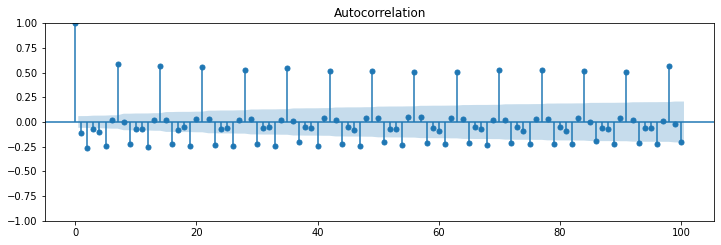

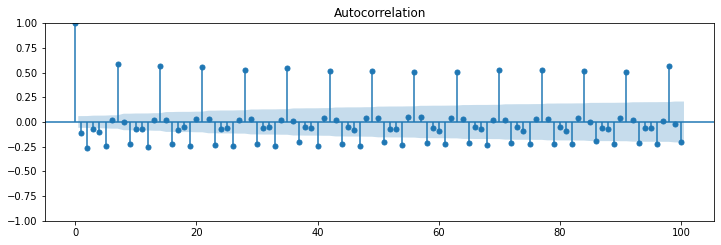

In [57]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
plot_acf(data['target'].values,
         lags=100,ax=ax1)

In [63]:
data.corr()[['zscore_7','target']]

,zscore_7,target
trend_temp,-0.041185,0.007397
trend_Percipitation,0.027331,0.030783
trend_WindSpeed,0.003640,0.007771
trend_MaxSustainedWind,0.026856,0.023415
trend_Gust,0.020930,0.009582
trend_Rain,0.071053,0.042583
trend_SnowDepth,0.001265,0.032648
trend_SnowIce,0.047270,0.063272
vol_temp,-0.006514,-0.006146
vol_Percipitation,-0.027704,-0.009230


<AxesSubplot:>

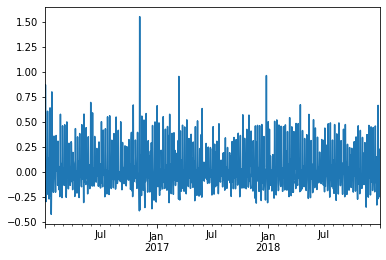

In [59]:
data['target'].plot()

<AxesSubplot:>

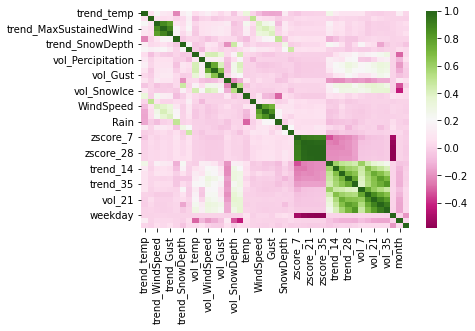

In [40]:
tmp = data.iloc[:,:-1].corr()
sns.heatmap(tmp,cmap='PiYG')

In [41]:
((data==0).sum()/data.shape[0]).to_frame().sort_values(0,ascending=False)

,0
holiday,0.973516
SnowIce,0.853881
SnowDepth,0.848402
trend_SnowDepth,0.735160
trend_SnowIce,0.539726
Rain,0.455708
Percipitation,0.337900
vol_SnowIce,0.231963
weekday,0.143379
Gust,0.050228


sparse_cols = ['SnowIce','SnowDepth','trend_SnowDepth','trend_SnowIce']
for col in sparse_cols:
    data = data.drop(col,1)

In [73]:
train = data[data.index<'2017-01-01']
val = data[(data.index>='2017-01-01') & (data.index<'2018-01-01') ]
test = data[data.index>='2018-01-01']

# Model

In [83]:
import xgboost as xgb
dtrain = xgb.DMatrix(train.iloc[:,:-1], label=train.iloc[:,-1:])
dval = xgb.DMatrix(val.iloc[:,:-1], label=val.iloc[:,-1:])
dtest = xgb.DMatrix(test.iloc[:,:-1], label=test.iloc[:,-1:])

In [84]:
param = {'max_depth': 5, 'eta': 1, 'objective': 'reg:squarederror'
        }
param['nthread'] = 4

In [85]:
evallist = [(dval, 'eval'), (dtrain, 'train')]

In [86]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-rmse:0.07626	train-rmse:0.06986
[1]	eval-rmse:0.06869	train-rmse:0.04313
[2]	eval-rmse:0.06613	train-rmse:0.03378
[3]	eval-rmse:0.06403	train-rmse:0.02628
[4]	eval-rmse:0.06484	train-rmse:0.01786
[5]	eval-rmse:0.06495	train-rmse:0.01436
[6]	eval-rmse:0.06577	train-rmse:0.01160
[7]	eval-rmse:0.06532	train-rmse:0.00935
[8]	eval-rmse:0.06543	train-rmse:0.00808
[9]	eval-rmse:0.06563	train-rmse:0.00686


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:528: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning


<AxesSubplot:>

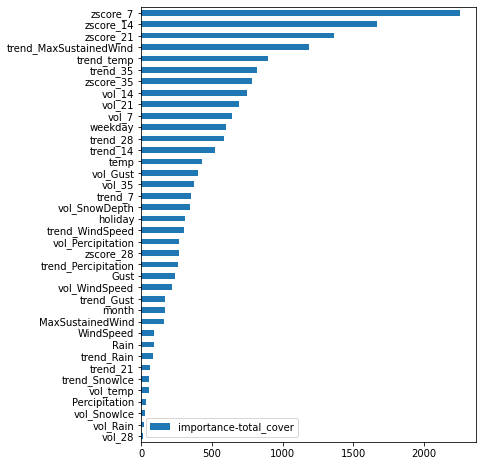

In [87]:
importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
importance_type = 'total_cover'
pd.DataFrame(bst.get_score(importance_type=importance_type),
            index=['importance-'+importance_type]).T.sort_values('importance-'+importance_type).plot(
kind='barh',figsize=(6,8))

# Predict and Performance

In [88]:
preds = bst.predict(dtest)

In [89]:
len(test)

365

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(mean_absolute_error(test.iloc[:,-1:], preds))
print(mean_squared_error(test.iloc[:,-1:], preds))

0.03727206645323343
0.0031558395306042148


In [91]:
sum((test.iloc[:,-1:]['target'].values*preds)>0)/365

0.9342465753424658

In [127]:
sum((test.iloc[:,-1:]['target'].values[7:]*preds[7:])>0)/(366-7)

0.9303621169916435

In [92]:
##baseline

window = 35
print(mean_absolute_error(test.iloc[:,-1:].iloc[(window+1):,:], 
                    test.iloc[:,-1:].rolling(window).mean().shift(1).iloc[(window+1):,:]))
print(mean_squared_error(test.iloc[:,-1:].iloc[(window+1):,:], 
                    test.iloc[:,-1:].rolling(window).mean().shift(1).iloc[(window+1):,:]))

0.13909789344776843
0.03704272762566622


In [93]:
from sklearn.linear_model import LinearRegression

In [94]:
reg = LinearRegression().fit(pd.concat([train,val])[['zscore_7']].iloc[7:,], 
                             pd.concat([train,val])['target'].iloc[7:,])

In [95]:
base = reg.predict(test[['zscore_7']].iloc[7:,])

In [97]:
print(mean_absolute_error(test.iloc[7:,-1:], 
                          base))
print(mean_squared_error(test.iloc[7:,-1:], 
                          base))

0.04487661501462303
0.004809602782770666


In [123]:
(pd.DataFrame(base)*test.iloc[7:,-1:].values>0).sum()/(366-7)

0    0.966574
dtype: float64

In [116]:
0.037674*test.iloc[7:,-1:].values[0]

array([0.00590957])

In [53]:
sum(
    (test.iloc[:,-1:].rolling(window).mean().shift(1).iloc[(window+1):,:]['target'].values*test.iloc[:,-1:].iloc[(window+1):,:]['target'].values)>0
)/(365-36)

0.3951367781155015

In [54]:
## error analysis

<AxesSubplot:>

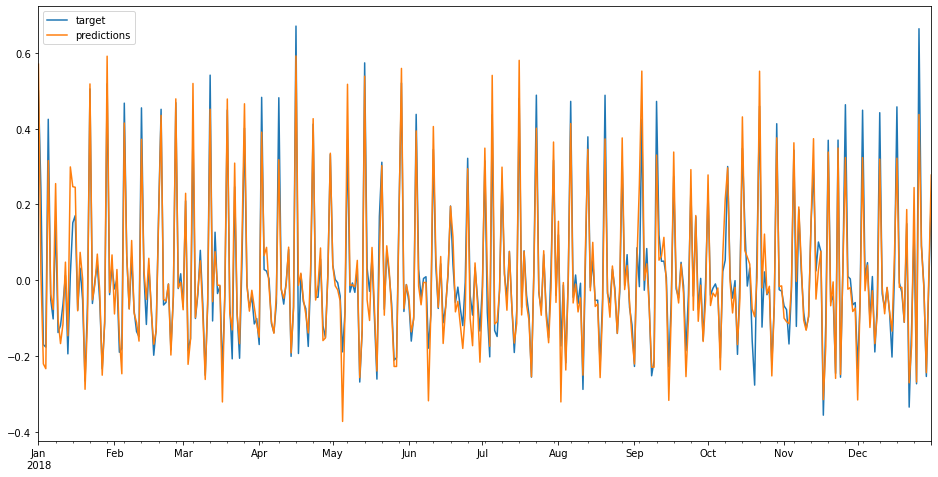

In [55]:
error_analysis = test.iloc[:,-1:].join(pd.DataFrame(preds,index=test.index).rename(
columns={0:'predictions'}
))
error_analysis.plot(figsize=(16,8)
)

In [56]:
import numpy as np
error_analysis['absolute_error'] = abs(error_analysis['target']-error_analysis['predictions'])
error_analysis['square_error'] = np.square(error_analysis['target']-error_analysis['predictions'])

<AxesSubplot:ylabel='month'>

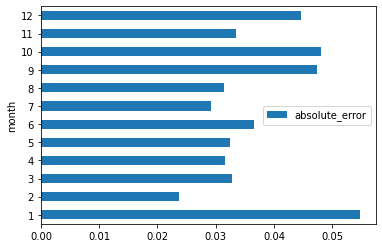

In [57]:
error_analysis['month']=[i.month for i in error_analysis.index]
error_analysis.groupby('month').mean()[['absolute_error']].plot(kind='barh')

<AxesSubplot:ylabel='month'>

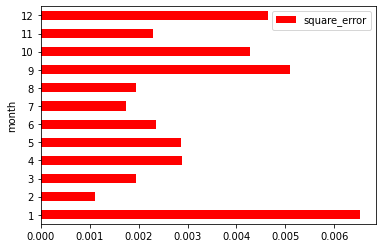

In [58]:
error_analysis['month']=[i.month for i in error_analysis.index]
error_analysis.groupby('month').mean()[['square_error']].plot(kind='barh',color='r')

<AxesSubplot:ylabel='Density'>

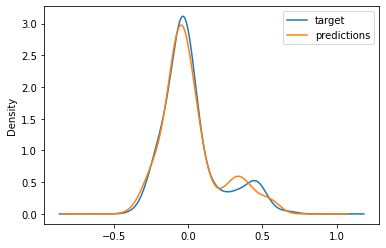

In [59]:
error_analysis = test.iloc[:,-1:].join(pd.DataFrame(preds,index=test.index).rename(
columns={0:'predictions'}
))
error_analysis.plot.kde()

array([[<AxesSubplot:title={'center':'target'}>,
        <AxesSubplot:title={'center':'predictions'}>]], dtype=object)

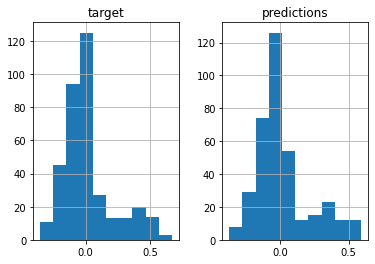

In [60]:
error_analysis.hist()

<AxesSubplot:xlabel='target', ylabel='Count'>

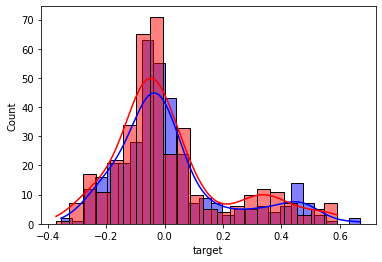

In [61]:
#sns.distplot(error_analysis)
sns.histplot(data=error_analysis, x="target", color="blue", label="Sepal Length", kde=True)
sns.histplot(data=error_analysis, x="predictions", color="red", label="Sepal Width", kde=True)

In [62]:
tmp = test.iloc[:,-1:]
tmp['type'] = ['target']*len(tmp)
pred_df = pd.DataFrame(preds).rename(
columns={0:'target'}
)
pred_df['type'] = ['predictions']*len(tmp)
tmp = pd.concat([tmp,pred_df])

<AxesSubplot:xlabel='target', ylabel='Density'>

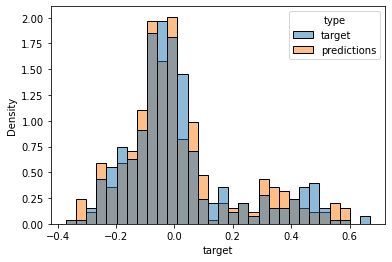

In [63]:
sns.histplot(data=tmp, x="target", hue="type",stat="density")


In [64]:
len(train.columns)

43

In [109]:
cols_self = [ 'zscore_7', 'zscore_14', 'zscore_21', 'zscore_28', 'zscore_35',
       'trend_7', 'trend_14', 'trend_21', 'trend_28', 'trend_35', 'vol_7',
       'vol_14', 'vol_21', 'vol_28', 'vol_35','weekday', 'month', 'holiday',
       'target']

cols_weather_only = ['trend_temp',
       'trend_Percipitation', 'trend_WindSpeed', 'trend_MaxSustainedWind',
       'trend_Gust', 'trend_Rain', 'trend_SnowDepth', 'trend_SnowIce',
       'vol_temp', 'vol_Percipitation', 'vol_WindSpeed',
       'vol_MaxSustainedWind', 'vol_Gust', 'vol_Rain', 'vol_SnowDepth',
       'vol_SnowIce', 'temp', 'Percipitation', 'WindSpeed', 'MaxSustainedWind',
       'Gust', 'Rain', 'SnowDepth', 'SnowIce', 
       #'target'
                    ]

cols_weather_only = ['trend_temp','vol_Percipitation']

cols_weather = cols_weather_only+['zscore_7', 'zscore_14', 'zscore_21', 'zscore_28', 'zscore_35',
       'trend_7', 'trend_14', 'trend_21', 'trend_28', 'trend_35', 'vol_7',
       'vol_14', 'vol_21', 'vol_28', 'vol_35','weekday', 'month', 'holiday',
       'target']

train_weather_excl = train[cols_self]
val_weather_excl = val[cols_self]
test_weather_excl = test[cols_self]


train_weather = train[cols_weather]
val_weather= val[cols_weather]
test_weather = test[cols_weather]

dtrain_weather_excl = xgb.DMatrix(train_weather_excl.iloc[:,:-1], label=train_weather_excl.iloc[:,-1:])
dval_weather_excl = xgb.DMatrix(val_weather_excl.iloc[:,:-1], label=val_weather_excl.iloc[:,-1:])
dtest_weather_excl = xgb.DMatrix(test_weather_excl.iloc[:,:-1], label=test_weather_excl.iloc[:,-1:])


dtrain_weather = xgb.DMatrix(train_weather.iloc[:,:-1], label=train_weather.iloc[:,-1:])
dval_weather = xgb.DMatrix(val_weather.iloc[:,:-1], label=val_weather.iloc[:,-1:])
dtest_weather = xgb.DMatrix(test_weather.iloc[:,:-1], label=test_weather.iloc[:,-1:])

In [110]:
param = {'max_depth': 5, 'eta': 1, 'objective': 'reg:squarederror'
        }
param['nthread'] = 4

In [111]:
evallist = [(dval_weather_excl, 'eval'), (dtrain_weather_excl, 'train')]
num_round = 10
bst_weather_excl = xgb.train(param, dtrain_weather_excl, num_round, evallist)

[0]	eval-rmse:0.07503	train-rmse:0.06996
[1]	eval-rmse:0.06552	train-rmse:0.04323
[2]	eval-rmse:0.06442	train-rmse:0.03379
[3]	eval-rmse:0.06170	train-rmse:0.03014
[4]	eval-rmse:0.05980	train-rmse:0.02235
[5]	eval-rmse:0.06037	train-rmse:0.01859
[6]	eval-rmse:0.06007	train-rmse:0.01374
[7]	eval-rmse:0.06081	train-rmse:0.01246
[8]	eval-rmse:0.05958	train-rmse:0.00987
[9]	eval-rmse:0.05967	train-rmse:0.00857


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:528: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning


In [112]:
preds_weather_excl = bst_weather_excl.predict(dtest_weather_excl)

In [113]:
# self only
print(mean_absolute_error(test.iloc[:,-1:], preds_weather_excl))
print(mean_squared_error(test.iloc[:,-1:], preds_weather_excl))

0.03039386617746826
0.0037019085535654425


In [114]:
(0.03727206645323343 - 0.03039386617746826)/0.03039386617746826

0.22630224913157485

In [115]:
(0.0031558395306042148 - 0.0037019085535654425)/0.0037019085535654425

-0.14751013296514004

In [116]:
param = {'max_depth': 5, 'eta': 1, 'objective': 'reg:squarederror'
        }
param['nthread'] = 4

evallist = [(dval_weather, 'eval'), (dtrain_weather, 'train')]

num_round = 10
bst_weather = xgb.train(param, dtrain_weather, num_round, evallist)

[0]	eval-rmse:0.07580	train-rmse:0.06987
[1]	eval-rmse:0.06665	train-rmse:0.04315
[2]	eval-rmse:0.06375	train-rmse:0.03213
[3]	eval-rmse:0.06252	train-rmse:0.02467
[4]	eval-rmse:0.06211	train-rmse:0.02201
[5]	eval-rmse:0.06231	train-rmse:0.01694
[6]	eval-rmse:0.06274	train-rmse:0.01516
[7]	eval-rmse:0.06280	train-rmse:0.01346
[8]	eval-rmse:0.06292	train-rmse:0.01175
[9]	eval-rmse:0.06333	train-rmse:0.00978


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:528: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning


In [117]:
preds_weather = bst_weather.predict(dtest_weather)

In [118]:
print(mean_absolute_error(test.iloc[:,-1:], preds_weather))
print(mean_squared_error(test.iloc[:,-1:], preds_weather))

0.030690640062358353
0.0023731616898061397


In [119]:
(0.030690640062358353 - 0.03039386617746826)/0.03039386617746826

0.009764268986289671

In [120]:
(0.0023731616898061397 - 0.0037019085535654425)/0.0037019085535654425

-0.35893562591640427

In [ ]:
pd.DataFrame(bst_weather.get_score(importance_type='gain'),
            index=['importance']).T.sort_values('importance').plot(
kind='barh',figsize=(10,10))